In [1]:
########################################################################
########################################################################
##                                                                    ##
##                      ORIGINAL _ DO NOT PUBLISH                     ##
##                                                                    ##
########################################################################
########################################################################

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 300

# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x
        
# Implements RNN Unit

class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        # self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2hidden = MatMul(input_size, hidden_size)
        self.prev_hidden2hidden = MatMul(hidden_size, hidden_size)
        self.hidden2out = MatMul(hidden_size, output_size)

    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):
        hidden_state = self.sigmoid(self.prev_hidden2hidden(hidden_state) + self.in2hidden(x))
        output = self.sigmoid(self.hidden2out(hidden_state))
        return output.squeeze(), hidden_state

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size).cuda()

# Implements GRU Unit

class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        self.update_gate = MatMul(input_size, hidden_size)
        self.reset_gate = MatMul(input_size, hidden_size)
        self.out_gate = MatMul(hidden_size, hidden_size)
        self.hidden2out = MatMul(hidden_size, output_size)

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        update = torch.sigmoid(self.update_gate(x))
        reset = torch.sigmoid(self.reset_gate(x))
        combined_reset = reset * hidden_state
        hidden_state = update * hidden_state + (1 - update) * torch.tanh(self.out_gate(combined_reset))
        output = self.hidden2out(hidden_state)
        return output.squeeze(), hidden_state

    def init_hidden(self, bs):
        return self.hidden_size


class ExMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExMLP, self).__init__()

        self.ReLU = torch.nn.ReLU()

        # Token-wise MLP network weights
        self.layer1 = MatMul(input_size,hidden_size)
        # additional layer(s)
        

    def name(self):
        return "MLP"

    def forward(self, x):

        # Token-wise MLP network implementation
        
        x = self.layer1(x)
        x = self.ReLU(x)
        # rest

        return x


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    pass
    # implement

# select model to use

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext

Using model: GRU
Epoch [1/10], Step [300/938], Train Loss: 0.6940, Test Loss: 0.7548
Epoch [1/10], Step [600/938], Train Loss: 0.7043, Test Loss: 0.6738
Epoch [1/10], Step [900/938], Train Loss: 0.6055, Test Loss: 0.5616
Accuracy: 0.6041666666666666
Epoch [2/10], Step [300/938], Train Loss: 0.4379, Test Loss: 0.5944
Epoch [2/10], Step [600/938], Train Loss: 0.4562, Test Loss: 0.6587
Epoch [2/10], Step [900/938], Train Loss: 0.4912, Test Loss: 0.6031
Accuracy: 0.6770833333333334
Epoch [3/10], Step [300/938], Train Loss: 0.5597, Test Loss: 0.4411
Epoch [3/10], Step [600/938], Train Loss: 0.4334, Test Loss: 0.4551
Epoch [3/10], Step [900/938], Train Loss: 0.4536, Test Loss: 0.4330
Accuracy: 0.8020833333333334
Epoch [4/10], Step [300/938], Train Loss: 0.4783, Test Loss: 0.4338
Epoch [4/10], Step [600/938], Train Loss: 0.4771, Test Loss: 0.6171
Epoch [4/10], Step [900/938], Train Loss: 0.4723, Test Loss: 0.5100
Accuracy: 0.7291666666666666
Epoch [5/10], Step [300/938], Train Loss: 0.5356, T

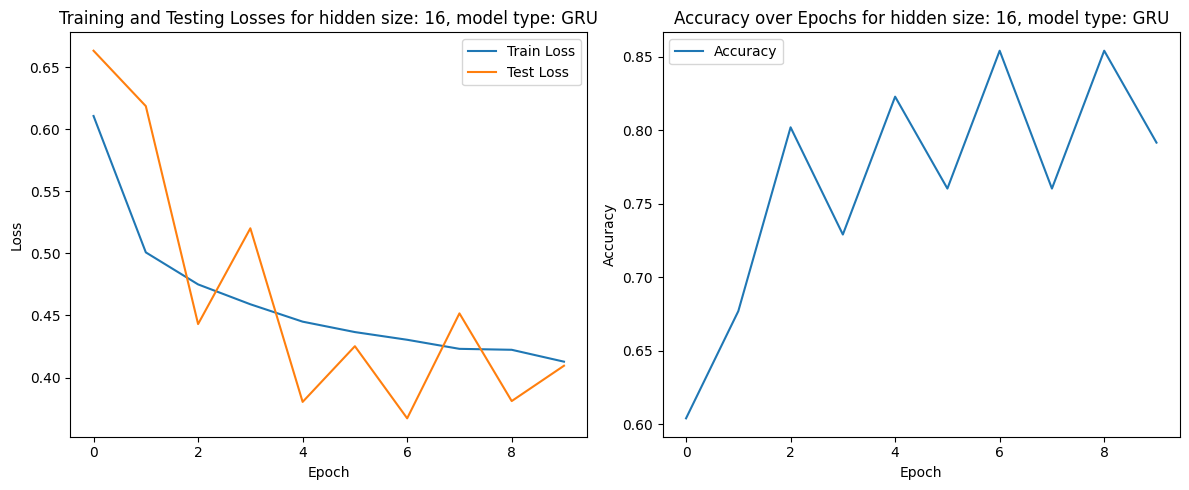

Using model: GRU
Epoch [1/10], Step [300/938], Train Loss: 0.6891, Test Loss: 0.7540
Epoch [1/10], Step [600/938], Train Loss: 0.6671, Test Loss: 0.5239
Epoch [1/10], Step [900/938], Train Loss: 0.5535, Test Loss: 0.5855
Accuracy: 0.65625
Epoch [2/10], Step [300/938], Train Loss: 0.5338, Test Loss: 0.4447
Epoch [2/10], Step [600/938], Train Loss: 0.5203, Test Loss: 0.6321
Epoch [2/10], Step [900/938], Train Loss: 0.4904, Test Loss: 0.5218
Accuracy: 0.75
Epoch [3/10], Step [300/938], Train Loss: 0.5556, Test Loss: 0.5153
Epoch [3/10], Step [600/938], Train Loss: 0.5095, Test Loss: 0.4713
Epoch [3/10], Step [900/938], Train Loss: 0.3584, Test Loss: 0.3559
Accuracy: 0.8125
Epoch [4/10], Step [300/938], Train Loss: 0.4261, Test Loss: 0.3634
Epoch [4/10], Step [600/938], Train Loss: 0.4845, Test Loss: 0.5646
Epoch [4/10], Step [900/938], Train Loss: 0.4599, Test Loss: 0.4665
Accuracy: 0.7916666666666666
Epoch [5/10], Step [300/938], Train Loss: 0.4152, Test Loss: 0.4695
Epoch [5/10], Step [

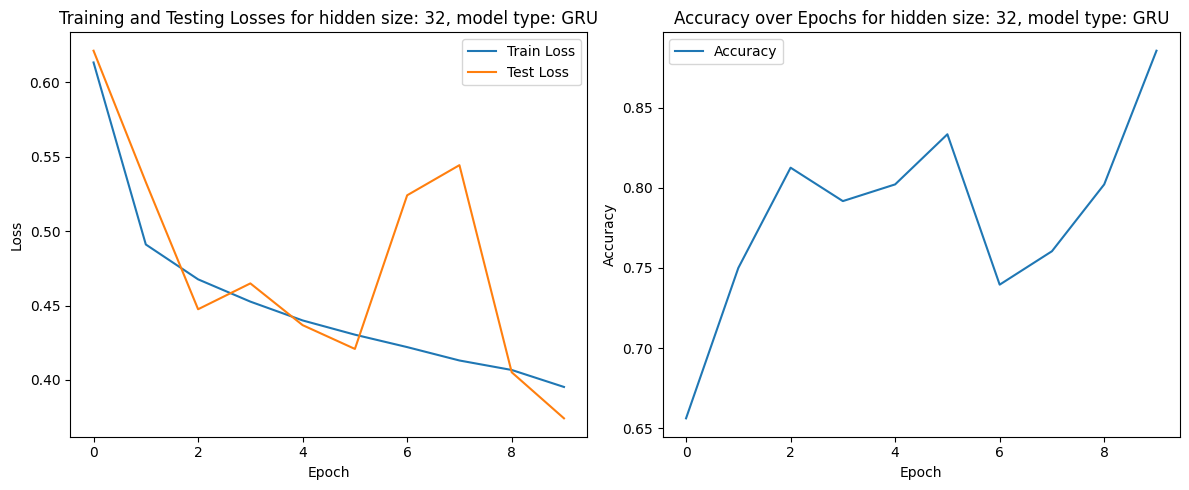

Using model: GRU
Epoch [1/10], Step [300/938], Train Loss: 0.7151, Test Loss: 0.7674
Epoch [1/10], Step [600/938], Train Loss: 0.5982, Test Loss: 0.6186
Epoch [1/10], Step [900/938], Train Loss: 0.5928, Test Loss: 0.4943
Accuracy: 0.6770833333333334
Epoch [2/10], Step [300/938], Train Loss: 0.4290, Test Loss: 0.4761
Epoch [2/10], Step [600/938], Train Loss: 0.3920, Test Loss: 0.4649
Epoch [2/10], Step [900/938], Train Loss: 0.5187, Test Loss: 0.6395
Accuracy: 0.7708333333333334
Epoch [3/10], Step [300/938], Train Loss: 0.4008, Test Loss: 0.4445
Epoch [3/10], Step [600/938], Train Loss: 0.5094, Test Loss: 0.3674
Epoch [3/10], Step [900/938], Train Loss: 0.5158, Test Loss: 0.5848
Accuracy: 0.78125
Epoch [4/10], Step [300/938], Train Loss: 0.4914, Test Loss: 0.4410
Epoch [4/10], Step [600/938], Train Loss: 0.5541, Test Loss: 0.5436
Epoch [4/10], Step [900/938], Train Loss: 0.6243, Test Loss: 0.3872
Accuracy: 0.8020833333333334
Epoch [5/10], Step [300/938], Train Loss: 0.4803, Test Loss: 0

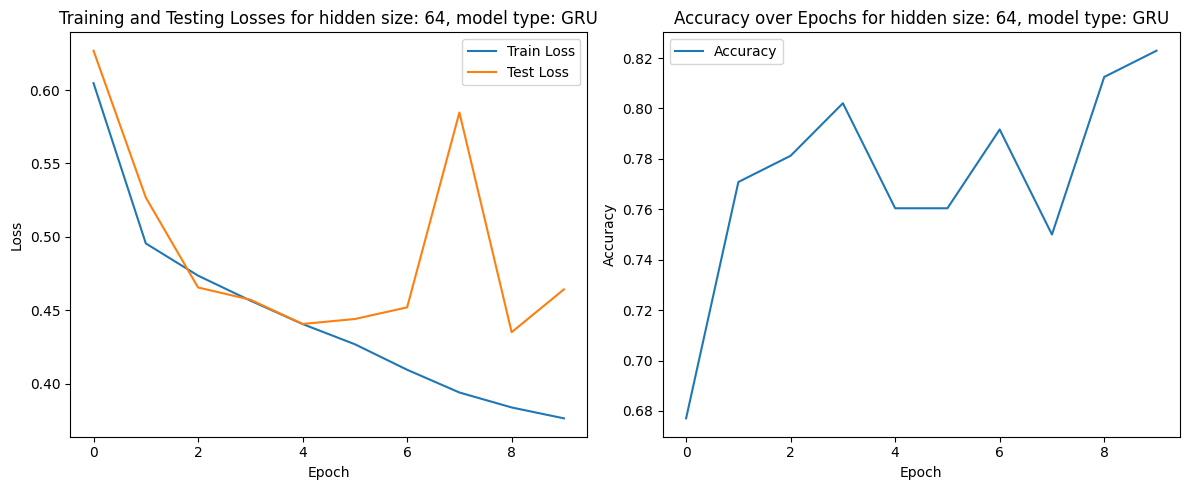

Using model: RNN
Epoch [1/10], Step [300/938], Train Loss: 0.6891, Test Loss: 0.7571
Epoch [1/10], Step [600/938], Train Loss: 0.6821, Test Loss: 0.7044
Epoch [1/10], Step [900/938], Train Loss: 0.6677, Test Loss: 0.6707
Accuracy: 0.5416666666666666
Epoch [2/10], Step [300/938], Train Loss: 0.7078, Test Loss: 0.6989
Epoch [2/10], Step [600/938], Train Loss: 0.7093, Test Loss: 0.6765
Epoch [2/10], Step [900/938], Train Loss: 0.7062, Test Loss: 0.6850
Accuracy: 0.5520833333333334
Epoch [3/10], Step [300/938], Train Loss: 0.7127, Test Loss: 0.6864
Epoch [3/10], Step [600/938], Train Loss: 0.6704, Test Loss: 0.6672
Epoch [3/10], Step [900/938], Train Loss: 0.5984, Test Loss: 0.6518
Accuracy: 0.5833333333333334
Epoch [4/10], Step [300/938], Train Loss: 0.6804, Test Loss: 0.7079
Epoch [4/10], Step [600/938], Train Loss: 0.7302, Test Loss: 0.7357
Epoch [4/10], Step [900/938], Train Loss: 0.6893, Test Loss: 0.6896
Accuracy: 0.5104166666666666
Epoch [5/10], Step [300/938], Train Loss: 0.7184, T

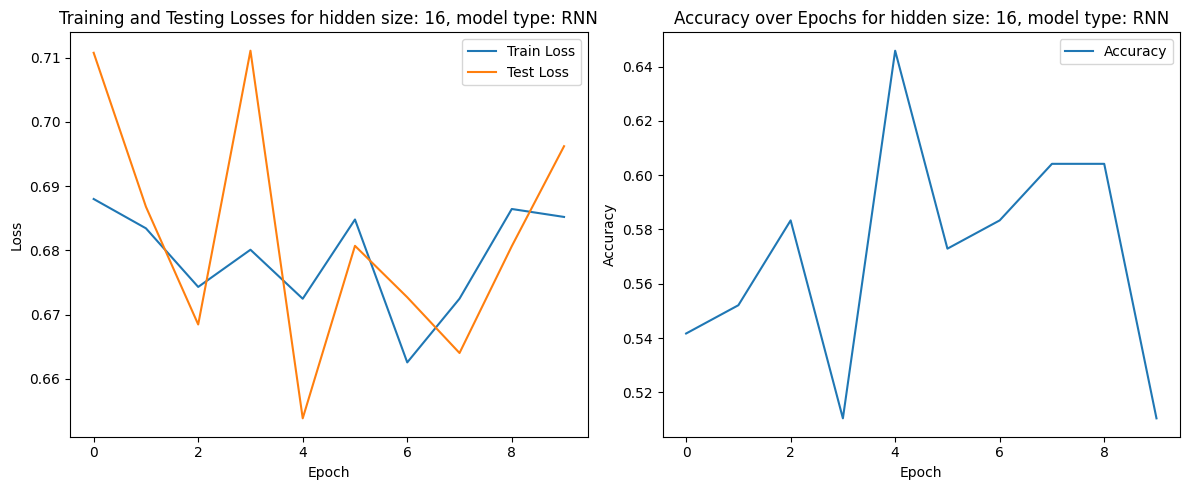

Using model: RNN
Epoch [1/10], Step [300/938], Train Loss: 0.6919, Test Loss: 0.7425
Epoch [1/10], Step [600/938], Train Loss: 0.6687, Test Loss: 0.7082
Epoch [1/10], Step [900/938], Train Loss: 0.6802, Test Loss: 0.6870
Accuracy: 0.53125
Epoch [2/10], Step [300/938], Train Loss: 0.6874, Test Loss: 0.6781
Epoch [2/10], Step [600/938], Train Loss: 0.6648, Test Loss: 0.6738
Epoch [2/10], Step [900/938], Train Loss: 0.7840, Test Loss: 0.6633
Accuracy: 0.59375
Epoch [3/10], Step [300/938], Train Loss: 0.6894, Test Loss: 0.6827
Epoch [3/10], Step [600/938], Train Loss: 0.6894, Test Loss: 0.6899
Epoch [3/10], Step [900/938], Train Loss: 0.6895, Test Loss: 0.6893
Accuracy: 0.5729166666666666
Epoch [4/10], Step [300/938], Train Loss: 0.7038, Test Loss: 0.6986
Epoch [4/10], Step [600/938], Train Loss: 0.7061, Test Loss: 0.7041
Epoch [4/10], Step [900/938], Train Loss: 0.6938, Test Loss: 0.6980
Accuracy: 0.4583333333333333
Epoch [5/10], Step [300/938], Train Loss: 0.6924, Test Loss: 0.6887
Epoch

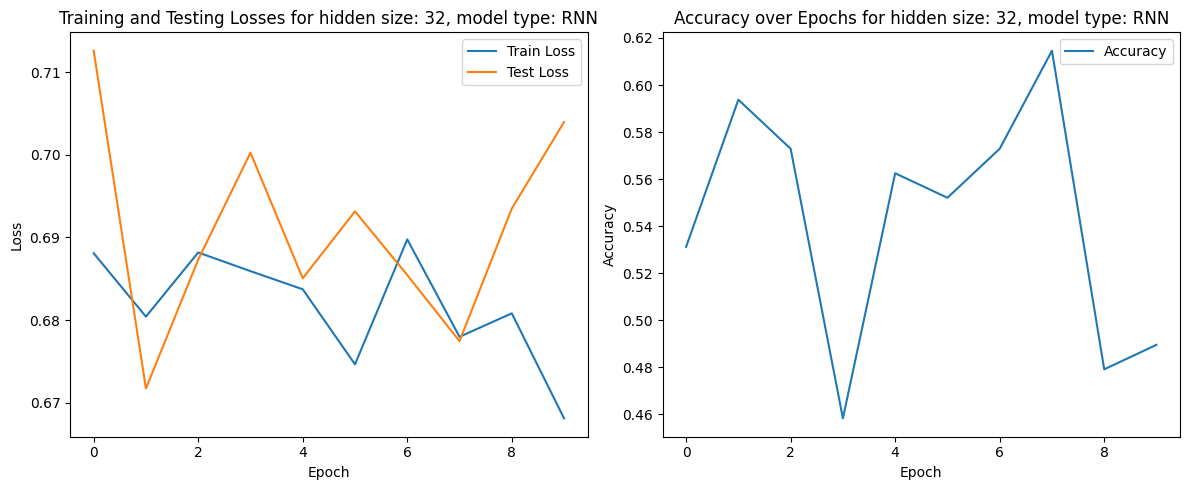

Using model: RNN
Epoch [1/10], Step [300/938], Train Loss: 0.6959, Test Loss: 0.7723
Epoch [1/10], Step [600/938], Train Loss: 0.6745, Test Loss: 0.6961
Epoch [1/10], Step [900/938], Train Loss: 0.7114, Test Loss: 0.7123
Accuracy: 0.4895833333333333
Epoch [2/10], Step [300/938], Train Loss: 0.6819, Test Loss: 0.7039
Epoch [2/10], Step [600/938], Train Loss: 0.6859, Test Loss: 0.6525
Epoch [2/10], Step [900/938], Train Loss: 0.6808, Test Loss: 0.6452
Accuracy: 0.6041666666666666
Epoch [3/10], Step [300/938], Train Loss: 0.6885, Test Loss: 0.6730
Epoch [3/10], Step [600/938], Train Loss: 0.6617, Test Loss: 0.6873
Epoch [3/10], Step [900/938], Train Loss: 0.6776, Test Loss: 0.6953
Accuracy: 0.5625
Epoch [4/10], Step [300/938], Train Loss: 0.6823, Test Loss: 0.7136
Epoch [4/10], Step [600/938], Train Loss: 0.6600, Test Loss: 0.6966
Epoch [4/10], Step [900/938], Train Loss: 0.6431, Test Loss: 0.7017
Accuracy: 0.4479166666666667
Epoch [5/10], Step [300/938], Train Loss: 0.7209, Test Loss: 0.

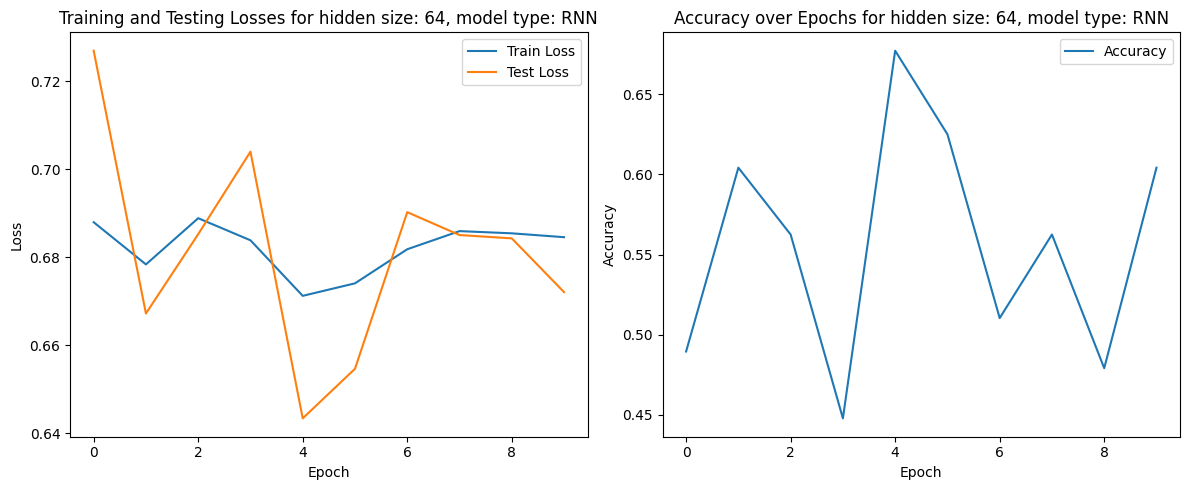

In [2]:
for use_RNN in [False, True]:
    for hidden_size in [16, 32, 64]:
        if use_RNN:
            model = ExRNN(input_size, output_size, hidden_size)
        else:
            model = ExGRU(input_size, output_size, hidden_size)

        print("Using model: " + model.name())

        if reload_model:
            print("Reloading model")
            model.load_state_dict(torch.load(model.name() + ".pth"))

        model.cuda()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loss = 1.0
        test_loss = 1.0

        # training steps in which a test step is executed every test_interval

        model.train()

        train_losses = []
        test_losses = []
        accuracies = []

        for epoch in range(num_epochs):

            itr = 0 # iteration counter within each epoch
            epoch_train_loss = 0
            epoch_test_loss = 0
            epoch_accuracies = []

            for labels, reviews, reviews_text in train_dataset:   # getting training batches

                # test if the model can predict allways False
                # labels = torch.arange(0, 2, dtype=torch.float32).repeat(1024,1).cuda()

                itr = itr + 1

                if (itr + 1) % test_interval == 0:
                    test_iter = True
                    labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
                else:
                    test_iter = False

                # Recurrent nets (RNN/GRU)

                if run_recurrent:
                    hidden_state = model.init_hidden(int(labels.shape[0]))

                    for i in range(num_words):
                        output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

                else:  

                # Token-wise networks (MLP / MLP + Atten.) 
                
                    sub_score = []
                    if atten_size > 0:  
                        # MLP + atten
                        sub_score, atten_weights = model(reviews)
                    else:               
                        # MLP
                        sub_score = model(reviews)

                    output = torch.mean(sub_score, 1)
                    
                # cross-entropy loss

                loss = criterion(output, labels)

                # optimize in training iterations

                if not test_iter:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # averaged losses
                if test_iter:
                    test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
                    epoch_test_loss += test_loss
                else:
                    train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss
                    epoch_train_loss += train_loss

                if test_iter:
                    accuracy = accuracy_score(torch.argmax(output, dim=1).cpu(), torch.argmax(labels, dim=1).cpu())
                    epoch_accuracies.append(accuracy)
                    print(
                        f"Epoch [{epoch + 1}/{num_epochs}], "
                        f"Step [{itr + 1}/{len(train_dataset)}], "
                        f"Train Loss: {train_loss:.4f}, "
                        f"Test Loss: {test_loss:.4f}"
                    )

                    if not run_recurrent:
                        nump_subs = sub_score.detach().numpy()
                        labels = labels.detach().numpy()
                        print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

                    # saving the model
                    torch.save(model, model.name() + "_" + str(hidden_size) + ".pth")
            print(f"Accuracy: {sum(epoch_accuracies) / len(epoch_accuracies)}")
            accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))    
            train_losses.append(epoch_train_loss / len(train_dataset))
            test_losses.append(epoch_test_loss / (len(train_dataset) // test_interval))


        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(num_epochs), train_losses, label='Train Loss')
        plt.plot(range(num_epochs), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Testing Losses for hidden size: {hidden_size}, model type: {"RNN" if use_RNN else "GRU"}')

        plt.subplot(1, 2, 2)
        plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy over Epochs for hidden size: {hidden_size}, model type: {"RNN" if use_RNN else "GRU"}')

        plt.tight_layout()
        plt.show()

In [27]:
from loader import preprocess_review, MAX_LENGTH

record = {
    'review': """Besides being boring, the scenes were oppressive and dark. The movie tried to portray some kind of moral, but fell flat with its message. What were the redeeming qualities?? On top of that, I don't think it could make librarians look any more unglamorous than it did.""",
    'sentiment': 'negative'
}




review_hard_for_rnn_rep = preprocess_review(record['review']).cuda()

rnn_model = torch.load("RNN_64.pth")

rnn_model.eval()

with torch.no_grad():
    hidden_state = rnn_model.init_hidden(1)

    for i in range(MAX_LENGTH):
        output, hidden_state = rnn_model(review_hard_for_rnn_rep[:,i,:], hidden_state)  # HIDE

rnn_pred = "positive" if output[0] > output[1] else "negative"

gru_model = torch.load("GRU_64.pth")

gru_model.eval()

with torch.no_grad():
    hidden_state = rnn_model.init_hidden(1)

    for i in range(MAX_LENGTH):
        output, hidden_state = gru_model(review_hard_for_rnn_rep[:,i,:], hidden_state)  # HIDE

gru_pred = "positive" if output[0] > output[1] else "negative"

print(f"GRU: {gru_pred}, RNN: {rnn_pred}, label: {record['sentiment']}, record: {record['review']}")

GRU: negative, RNN: positive, label: negative, record: Besides being boring, the scenes were oppressive and dark. The movie tried to portray some kind of moral, but fell flat with its message. What were the redeeming qualities?? On top of that, I don't think it could make librarians look any more unglamorous than it did.
